# 住宅価格の予測
AutoMLにより、住宅の価格を予測します。

ライブラリのインストール

今回はAutoMLを実践するためにAutoMLのOSSライブラリを用いる。  

PyCaretのインストール  
AutoMLをサポートするライブラリ、PyCaretをバージョンを指定してインストールします。

In [2]:
#!pip install pycaret==2.3.6

In [3]:
#!pip install pandas-profiling==3.1.0

In [2]:
import pandas as pd
import numpy as np

import pycaret

#compare_models関数は、ライブラリ内のすべてのモデルを使って訓練を行い、スコアを評価する。
#回帰問題なので'refression'を指定
from pycaret.regression import compare_models

#models関数により、すべての使用可能な機械学習モデルを確認できる。
from pycaret.regression import models

#ceate_model関数:「交差検証」を用いて個別のモデルの訓練と評価を行う。  
from pycaret.regression import create_model

#tune_model関数を用いて、ハイパーパラメータを最適化する。
from pycaret.regression import tune_model

#plot_model関数を使い、各特徴量の重要度をプロットする、
from pycaret.regression import plot_model

#finalize_model関数により、すべての訓練データを使ってモデルを訓練し、本番用のモデルを作成できるようにする。
from pycaret.regression import finalize_model

from pycaret.regression import predict_model

補足  
pycaretのpip installはanaconda環境が動作しなくなる恐れがあるようなので、新たに仮想環境を作ってimportする。

データの読み込み

In [3]:
train_data = pd.read_csv("train.csv")  # 訓練データ
test_data = pd.read_csv("test.csv") # テストデータ

train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 環境の設定
PyCaretの環境を設定  
setup関数はPyCaretの環境を初期化しますが、PyCaretの他の関数を実行する前に呼び出す必要がある。  
データの型に問題が無ければ、空白を入力することで設定を完了することができる。  

今回のデータには一部欠損があるので、欠損データに対する対応を設定する必要がある。  
numeric_imputation="mean"により数値データの欠損には平均値があてがわれ、categorical_imputation="mode"によりカテゴリデータの欠損には最頻値があてがわれます。

In [4]:
#setup関数をimport
from pycaret.regression import setup

#
clf = setup(data=train_data, 
            target="SalePrice",  #正解データを指定
            session_id=123,  # 環境の初期化
            numeric_imputation="mean",  #欠損値には平均値をあてはめる
            categorical_imputation="mode")  #カテゴリ変数の欠損値に対する処理に最頻値をあてはめる

,Description,Value
0,session_id,123
1,Target,SalePrice
2,Original Data,"(1460, 81)"
3,Missing Values,True
4,Numeric Features,19
5,Categorical Features,61
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1021, 398)"


### モデルの比較  
様々なモデルを比較して、性能を評価する

In [6]:
#全てのモデルを訓練し、評価する。
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,18267.4577,904388461.7410,29339.4323,0.8654,0.1442,0.1068,0.4780
lightgbm,Light Gradient Boosting Machine,18387.7426,949101768.2171,30135.4130,0.8597,0.1513,0.1092,0.1300
rf,Random Forest Regressor,19530.1036,1114949035.3745,32545.4917,0.8357,0.1598,0.1158,1.3740
ada,AdaBoost Regressor,26628.4868,1382583891.1726,36800.4564,0.7901,0.2117,0.1743,0.6750
omp,Orthogonal Matching Pursuit,18768.1863,1464364090.8651,35579.2317,0.7730,0.1652,0.1103,0.0340
ridge,Ridge Regression,20431.5355,1531022075.7576,36904.2721,0.7655,0.1980,0.1240,0.0460
et,Extra Trees Regressor,22532.4745,1599822063.6999,39045.1818,0.7586,0.1827,0.1310,1.8360
en,Elastic Net,21630.4732,1709783277.3609,38550.6647,0.7477,0.1728,0.1271,0.1710
lasso,Lasso Regression,20692.9474,1763483275.3637,39197.2769,0.7236,0.2035,0.1260,0.1590
br,Bayesian Ridge,25735.1278,2119378060.5866,43569.9500,0.6838,0.2080,0.1514,0.2130


一番上が'gbr'  
次の'lightgbm'(gbrの一部)

In [7]:
#最もスコアの良いモデルの概要を表示する。
print(best_model)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=123, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


### モデルの作成  

In [10]:
#models関数により、すべての使用可能な機械学習モデルを確認
#機械学習モデルの一覧
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


今回は最も精度が高かった「勾配ブースティング」による回帰(gbr)のモデルを作成する。

In [12]:
#ceate_model関数:「交差検証」を用いて個別のモデルの訓練と評価を行う。  
#勾配ブースティングのモデルを作成
gbr=create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,21546.9403,2088336230.4049,45698.3176,0.7449,0.1802,0.1222
1,17908.3542,726829856.2722,26959.7822,0.8866,0.1343,0.0975
2,15004.5923,468983175.6993,21656.0194,0.8985,0.1363,0.0980
3,15526.7373,671327666.6994,25909.9916,0.8706,0.1270,0.0901
4,21192.0733,1324178784.2308,36389.2674,0.8653,0.1921,0.1406
5,18680.7140,937196023.6915,30613.6575,0.8702,0.1398,0.1070
6,17861.7111,680518979.5857,26086.7587,0.8556,0.1254,0.0996
7,19172.8095,830312705.6369,28815.1472,0.8782,0.1520,0.1122
8,19477.1321,711024586.1001,26665.0443,0.8939,0.1410,0.1137


訓練済みモデルの概要、ハイパーパラメータ一覧を表示

In [13]:
print(gbr)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=123, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


#### ハイパーパラメータの調節

In [18]:
#tune_model関数を用いて、ハイパーパラメータを最適化する。

tuned_gbr = tune_model(gbr)  #ハイパーパラメータが自動で調整される。

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,23118.4475,2877632227.9818,53643.5665,0.6485,0.2101,0.1391
1,18175.8825,765896326.8012,27674.8320,0.8805,0.1325,0.0992
2,14744.5445,368079439.7154,19185.3965,0.9203,0.1247,0.0953
3,18394.7329,846904607.8046,29101.6255,0.8367,0.1543,0.1123
4,21844.1701,1795176612.7528,42369.5246,0.8174,0.1864,0.1314
5,17346.7198,772566445.6565,27795.0795,0.8930,0.1528,0.1062
6,16926.5698,691879686.1680,26303.6060,0.8532,0.1229,0.0917
7,19988.4873,1023746338.1098,31996.0363,0.8498,0.1573,0.1154
8,20185.5194,1020909078.1980,31951.6678,0.8476,0.1584,0.1179


ハイパーパラメータを調整済みの、モデルの概要を表示する。

In [19]:
print(tuned_gbr)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.15, loss='ls', max_depth=7,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.02, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=230,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=123, subsample=0.85, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


先ほどと比べるといくらかハイパーパラメータが変わっている。

### モデルを評価する

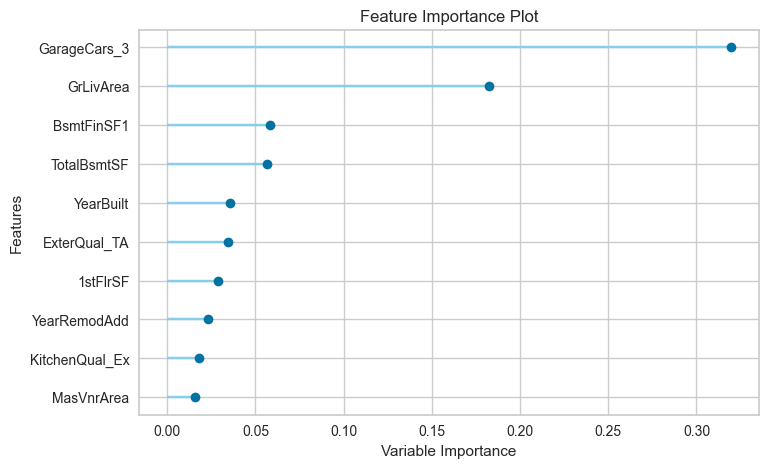

In [21]:
#plot_model関数を使い、各特徴量の重要度をプロットする

plot_model(tuned_gbr,plot='feature')  #各特徴量の重要度をプロット

車のガレージ数の特徴量が重要だとわかる。

### 本番用のモデルを作成  

In [23]:
#finalize_model関数により、すべての訓練データを使ってモデルを訓練し、本番用のモデルを作成できるようにする。

final_gbr = finalize_model(tuned_gbr) #最終的なモデル
print(final_gbr)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.15, loss='ls', max_depth=7,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.02, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=230,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=123, subsample=0.85, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


### 提出用のデータを作成  
テストデータを使用して、予測  
予測結果には、予測値を表す「Label」列が含まれる。

In [26]:
test_pred = predict_model(final_gbr,data=test_data)
test_pred.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Label
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,141832.893778
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,170747.691126
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,195601.047215
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,204583.914022
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,188421.804700


形式を整えたうえで、Kaggleに提出するためのcsvファイルを保存する。

In [28]:
#形式を整える
subm_data = test_pred[['Id','Label']]  #列を抜き出す
subm_data = subm_data.rename(columns={'Label':'SalePrice'}) #列名の変更

#提出用のcsvファイルを保存 
subm_data.to_csv('submissin_houseprices.csv',index=False)

subm_data

,Id,SalePrice
0,1461,141832.893778
1,1462,170747.691126
2,1463,195601.047215
3,1464,204583.914022
4,1465,188421.804700
...,...,...
1454,2915,83311.800052
1455,2916,85777.934997
1456,2917,177696.369451
1457,2918,124306.735088


### Kaggle提出  
### 評価  
0.15807  
2290位/3969位